In [1]:
#---------------------------------Torch Modules --------------------------------------------------------
from __future__ import print_function
import numpy as np
import pandas as pd
import torch.nn as nn
import math
import torch.nn.functional as F
import torch
import torchvision
from torch.nn import init
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt

In [2]:
###-----------------------------------variables-----------------------------------------------
# for Normalization
mean = [0.5]
std = [0.5]
# batch size
BATCH_SIZE = 31
Iterations = 5
learning_rate = 0.001

In [3]:
##-----------------------------------Commands to download and perpare the MNIST dataset ------------------------------------
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])


train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./mnist', train=True, download=True,
                       transform=train_transform),
        batch_size=BATCH_SIZE, shuffle=True) # train dataset

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./mnist', train=False,
                         transform=test_transform),
        batch_size=BATCH_SIZE, shuffle=False) # test dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 27431940.09it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1197265.13it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9026210.35it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8429437.51it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 29801240.95it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1325959.63it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8919495.51it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 488525.20it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



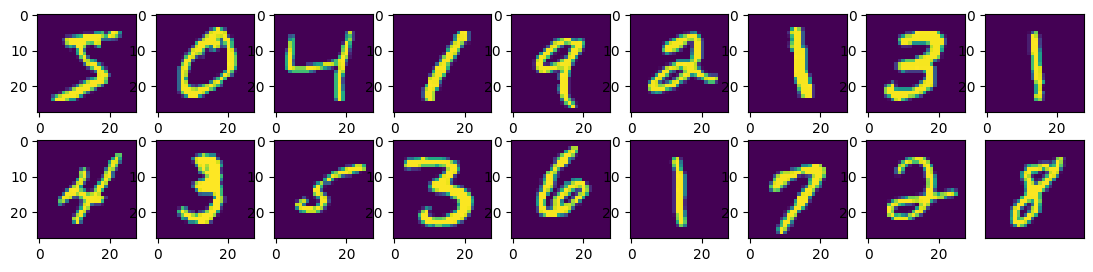

In [4]:

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
      if torch.is_tensor(img):
        # Tensor Image
        ax.imshow(img.numpy())
    else:
      # PIL Image
      ax.imshow(img)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
    return axes
mnist_train = torchvision.datasets.MNIST(root="../data", train=True,
transform=train_transform,
download=True)
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9);


In [5]:
# Same as linear regression!
class SoftmaxRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftmaxRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [6]:
input_dim = 28*28
output_dim = 10

model = SoftmaxRegressionModel(input_dim, output_dim)

In [7]:
## Loss function
criterion = torch.nn.CrossEntropyLoss() # pytorch's cross entropy loss function

# definin which paramters to train only the CNN model parameters
optimizer = torch.optim.SGD(model.parameters(),learning_rate)

In [8]:
# defining the training function
# Train baseline classifier on clean data
def train(model, optimizer,criterion,epoch):
    model.train() # setting up for training
    for batch_idx, (data, target) in enumerate(train_loader): # data contains the image and target contains the label = 0/1/2/3/4/5/6/7/8/9
        data = data.view(-1, 28*28).requires_grad_()
        optimizer.zero_grad() # setting gradient to zero
        output = model(data) # forward
        loss = criterion(output, target) # loss computation
        loss.backward() # back propagation here pytorch will take care of it
        optimizer.step() # updating the weight values
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
# to evaluate the model
## validation of test accuracy
def test(model, criterion, val_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.view(-1, 28*28).requires_grad_()
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # if pred == target then correct +=1

    test_loss /= len(val_loader.dataset) # average test loss
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, val_loader.sampler.__len__(),
        100. * correct / val_loader.sampler.__len__() ))

In [10]:
## training the logistic model
for i in range(Iterations):
    train(model, optimizer,criterion,i)
    test(model, criterion, test_loader, i) #Testing the the current CNN
    torch.save(model,'mnist.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.521028
Train Epoch: 0 [3100/60000 (5%)]	Loss: 1.773771
Train Epoch: 0 [6200/60000 (10%)]	Loss: 1.657862
Train Epoch: 0 [9300/60000 (15%)]	Loss: 1.605850
Train Epoch: 0 [12400/60000 (21%)]	Loss: 1.463662
Train Epoch: 0 [15500/60000 (26%)]	Loss: 1.277197
Train Epoch: 0 [18600/60000 (31%)]	Loss: 1.430853
Train Epoch: 0 [21700/60000 (36%)]	Loss: 1.174922
Train Epoch: 0 [24800/60000 (41%)]	Loss: 0.951727
Train Epoch: 0 [27900/60000 (46%)]	Loss: 0.749819
Train Epoch: 0 [31000/60000 (52%)]	Loss: 0.894521
Train Epoch: 0 [34100/60000 (57%)]	Loss: 0.855961
Train Epoch: 0 [37200/60000 (62%)]	Loss: 0.819895
Train Epoch: 0 [40300/60000 (67%)]	Loss: 0.689629
Train Epoch: 0 [43400/60000 (72%)]	Loss: 0.968970
Train Epoch: 0 [46500/60000 (77%)]	Loss: 0.692913
Train Epoch: 0 [49600/60000 (83%)]	Loss: 0.860058
Train Epoch: 0 [52700/60000 (88%)]	Loss: 0.819084
Train Epoch: 0 [55800/60000 (93%)]	Loss: 0.762307
Train Epoch: 0 [58900/60000 (98%)]	Loss: 0.510898

Test set

In [11]:
model = SoftmaxRegressionModel(input_dim, output_dim)
# definin which paramters to train only the CNN model parameters
optimizer = torch.optim.SGD(model.parameters(),learning_rate)
## training the logistic model
for i in range(3):
    train(model, optimizer,criterion,i)
    test(model, criterion, train_loader, i) #Testing the the current CNN
    test(model, criterion, test_loader, i) #Testing the the current CNN
    torch.save(model,'mnist.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.371270
Train Epoch: 0 [3100/60000 (5%)]	Loss: 1.890470
Train Epoch: 0 [6200/60000 (10%)]	Loss: 1.649776
Train Epoch: 0 [9300/60000 (15%)]	Loss: 1.356679
Train Epoch: 0 [12400/60000 (21%)]	Loss: 1.390749
Train Epoch: 0 [15500/60000 (26%)]	Loss: 1.205911
Train Epoch: 0 [18600/60000 (31%)]	Loss: 0.934181
Train Epoch: 0 [21700/60000 (36%)]	Loss: 1.224912
Train Epoch: 0 [24800/60000 (41%)]	Loss: 1.123318
Train Epoch: 0 [27900/60000 (46%)]	Loss: 1.009500
Train Epoch: 0 [31000/60000 (52%)]	Loss: 0.713064
Train Epoch: 0 [34100/60000 (57%)]	Loss: 0.929472
Train Epoch: 0 [37200/60000 (62%)]	Loss: 0.820657
Train Epoch: 0 [40300/60000 (67%)]	Loss: 0.713153
Train Epoch: 0 [43400/60000 (72%)]	Loss: 0.778878
Train Epoch: 0 [46500/60000 (77%)]	Loss: 0.723041
Train Epoch: 0 [49600/60000 (83%)]	Loss: 0.647330
Train Epoch: 0 [52700/60000 (88%)]	Loss: 0.623356
Train Epoch: 0 [55800/60000 (93%)]	Loss: 0.661700
Train Epoch: 0 [58900/60000 (98%)]	Loss: 0.686161

Test set

In [12]:
# L2 Regularization
def train(model, optimizer,criterion,epoch):
    model.train() # setting up for training
    for batch_idx, (data, target) in enumerate(train_loader): # data contains the image and target contains the label = 0/1/2/3/4/5/6/7/8/9
        data = data.view(-1, 28*28).requires_grad_()
        optimizer.zero_grad() # setting gradient to zero
        output = model(data) # forward
        sums =0
        for name, param in model.named_parameters():
            sums = param.data.pow(2).sum()
            break
        loss = criterion(output, target) + 0.00005 * sums # loss computation
        loss.backward() # back propagation here pytorch will take care of it
        optimizer.step() # updating the weight values
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [13]:
model = SoftmaxRegressionModel(input_dim, output_dim)
# definin which paramters to train only the CNN model parameters
optimizer = torch.optim.SGD(model.parameters(),learning_rate)
## training the logistic model
for i in range(3):
    train(model, optimizer,criterion,i)
    test(model, criterion, train_loader, i) #Testing the the current CNN
    test(model, criterion, test_loader, i) #Testing the the current CNN
    torch.save(model,'mnist.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.733225
Train Epoch: 0 [3100/60000 (5%)]	Loss: 2.001191
Train Epoch: 0 [6200/60000 (10%)]	Loss: 1.661482
Train Epoch: 0 [9300/60000 (15%)]	Loss: 1.256233
Train Epoch: 0 [12400/60000 (21%)]	Loss: 1.398032
Train Epoch: 0 [15500/60000 (26%)]	Loss: 1.243362
Train Epoch: 0 [18600/60000 (31%)]	Loss: 1.180142
Train Epoch: 0 [21700/60000 (36%)]	Loss: 0.990190
Train Epoch: 0 [24800/60000 (41%)]	Loss: 0.794583
Train Epoch: 0 [27900/60000 (46%)]	Loss: 1.018447
Train Epoch: 0 [31000/60000 (52%)]	Loss: 0.861440
Train Epoch: 0 [34100/60000 (57%)]	Loss: 0.778872
Train Epoch: 0 [37200/60000 (62%)]	Loss: 0.816043
Train Epoch: 0 [40300/60000 (67%)]	Loss: 0.759267
Train Epoch: 0 [43400/60000 (72%)]	Loss: 0.670397
Train Epoch: 0 [46500/60000 (77%)]	Loss: 0.714371
Train Epoch: 0 [49600/60000 (83%)]	Loss: 0.787143
Train Epoch: 0 [52700/60000 (88%)]	Loss: 0.800165
Train Epoch: 0 [55800/60000 (93%)]	Loss: 0.686135
Train Epoch: 0 [58900/60000 (98%)]	Loss: 0.605999

Test set

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)